# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

子目录或文件 data 已经存在。


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:24, 7.36MB/s]                                                                                                                                                                                                  
SVHN Training Set: 64.3MB [00:09, 7.10MB/s]                                                                                                                                                                                                 


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

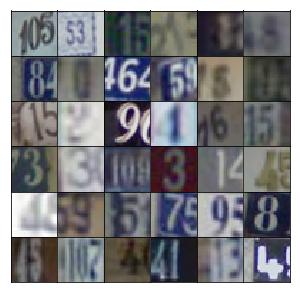

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [34]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)        
        # now (4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        # now (4, 4, 512)
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # now (8, 8, 256)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # now (16, 16, 128)
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # now (32, 32, 3)
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [35]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # now (16, 16, 64)

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # now (8, 8, 128)

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # now (4, 4, 256)
        
        flatten = tf.reshape(x3, (-1, 4*4*256))
        
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [36]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [37]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [38]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [39]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an errror without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [40]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very senstive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [ ]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

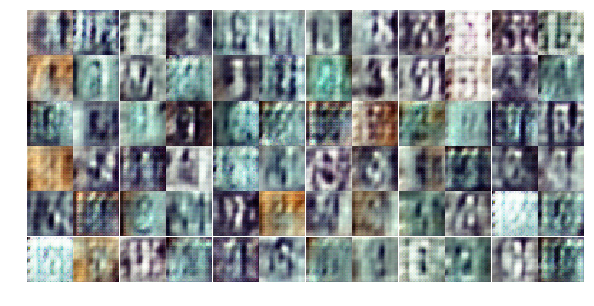

Epoch 3/25... Discriminator Loss: 1.2425... Generator Loss: 0.6513
Epoch 3/25... Discriminator Loss: 1.2426... Generator Loss: 0.8603
Epoch 3/25... Discriminator Loss: 1.1226... Generator Loss: 0.7933
Epoch 3/25... Discriminator Loss: 1.0920... Generator Loss: 1.0441
Epoch 3/25... Discriminator Loss: 1.2325... Generator Loss: 0.8402
Epoch 3/25... Discriminator Loss: 1.1220... Generator Loss: 1.0512
Epoch 3/25... Discriminator Loss: 1.2656... Generator Loss: 0.7878
Epoch 3/25... Discriminator Loss: 1.1860... Generator Loss: 0.8249
Epoch 3/25... Discriminator Loss: 1.0770... Generator Loss: 0.6850
Epoch 3/25... Discriminator Loss: 1.3868... Generator Loss: 0.6165


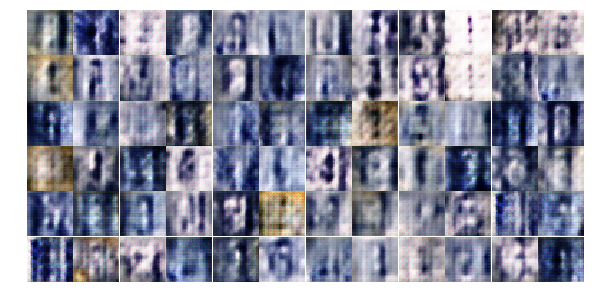

Epoch 3/25... Discriminator Loss: 1.1215... Generator Loss: 0.8054
Epoch 3/25... Discriminator Loss: 1.3392... Generator Loss: 0.8157
Epoch 3/25... Discriminator Loss: 1.2018... Generator Loss: 0.6209
Epoch 3/25... Discriminator Loss: 1.2418... Generator Loss: 0.8056
Epoch 3/25... Discriminator Loss: 1.1965... Generator Loss: 1.0461
Epoch 3/25... Discriminator Loss: 1.2667... Generator Loss: 0.6812
Epoch 3/25... Discriminator Loss: 1.2697... Generator Loss: 0.8540
Epoch 3/25... Discriminator Loss: 1.3172... Generator Loss: 0.7406
Epoch 3/25... Discriminator Loss: 1.2869... Generator Loss: 0.8149
Epoch 3/25... Discriminator Loss: 0.9471... Generator Loss: 0.8349


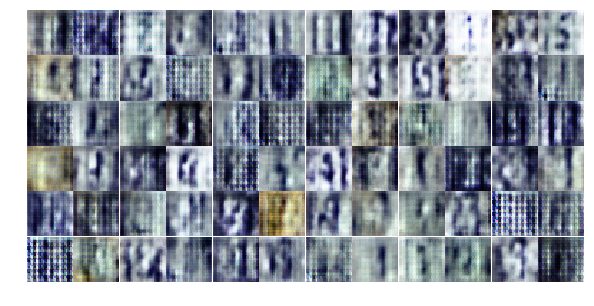

Epoch 3/25... Discriminator Loss: 1.2812... Generator Loss: 0.7616
Epoch 3/25... Discriminator Loss: 1.0255... Generator Loss: 0.9806
Epoch 3/25... Discriminator Loss: 1.0909... Generator Loss: 1.0518
Epoch 3/25... Discriminator Loss: 1.2960... Generator Loss: 0.7961
Epoch 3/25... Discriminator Loss: 1.4140... Generator Loss: 0.7100
Epoch 3/25... Discriminator Loss: 1.2751... Generator Loss: 0.8133
Epoch 3/25... Discriminator Loss: 1.1983... Generator Loss: 0.9163
Epoch 3/25... Discriminator Loss: 1.0589... Generator Loss: 1.1120
Epoch 3/25... Discriminator Loss: 1.4512... Generator Loss: 1.1064
Epoch 3/25... Discriminator Loss: 1.4834... Generator Loss: 0.5828


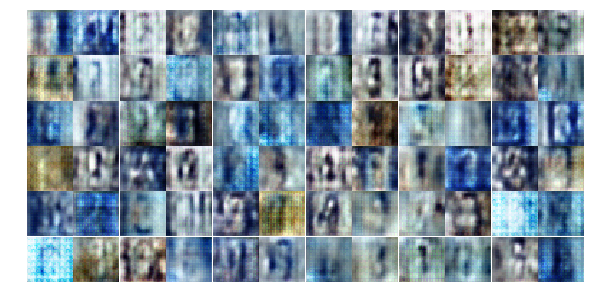

Epoch 3/25... Discriminator Loss: 1.4153... Generator Loss: 0.7099
Epoch 4/25... Discriminator Loss: 1.2687... Generator Loss: 0.6196
Epoch 4/25... Discriminator Loss: 1.3810... Generator Loss: 1.2125
Epoch 4/25... Discriminator Loss: 1.0478... Generator Loss: 0.7799
Epoch 4/25... Discriminator Loss: 1.2567... Generator Loss: 1.0474
Epoch 4/25... Discriminator Loss: 1.1822... Generator Loss: 0.8575
Epoch 4/25... Discriminator Loss: 1.2881... Generator Loss: 0.6537
Epoch 4/25... Discriminator Loss: 1.2734... Generator Loss: 0.6347
Epoch 4/25... Discriminator Loss: 1.3762... Generator Loss: 0.7059
Epoch 4/25... Discriminator Loss: 1.3149... Generator Loss: 0.7242


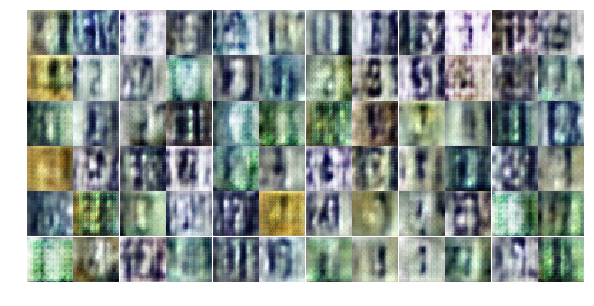

Epoch 4/25... Discriminator Loss: 1.3897... Generator Loss: 1.0373
Epoch 4/25... Discriminator Loss: 1.1441... Generator Loss: 0.7078
Epoch 4/25... Discriminator Loss: 1.2757... Generator Loss: 0.7788
Epoch 4/25... Discriminator Loss: 1.2553... Generator Loss: 0.9582
Epoch 4/25... Discriminator Loss: 1.1453... Generator Loss: 0.9938
Epoch 4/25... Discriminator Loss: 1.3798... Generator Loss: 0.5149
Epoch 4/25... Discriminator Loss: 1.3200... Generator Loss: 0.7753
Epoch 4/25... Discriminator Loss: 1.1638... Generator Loss: 0.7901
Epoch 4/25... Discriminator Loss: 1.2822... Generator Loss: 1.0892
Epoch 4/25... Discriminator Loss: 1.2259... Generator Loss: 0.8620


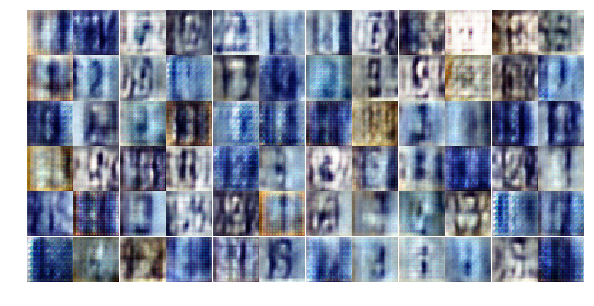

Epoch 4/25... Discriminator Loss: 1.2731... Generator Loss: 0.6887
Epoch 4/25... Discriminator Loss: 1.0300... Generator Loss: 1.1955
Epoch 4/25... Discriminator Loss: 1.3078... Generator Loss: 0.7875
Epoch 4/25... Discriminator Loss: 1.3507... Generator Loss: 0.7772
Epoch 4/25... Discriminator Loss: 1.1277... Generator Loss: 0.7951
Epoch 4/25... Discriminator Loss: 1.2937... Generator Loss: 0.9987
Epoch 4/25... Discriminator Loss: 1.4080... Generator Loss: 0.8275
Epoch 4/25... Discriminator Loss: 1.0037... Generator Loss: 0.8496
Epoch 4/25... Discriminator Loss: 1.2661... Generator Loss: 0.7579
Epoch 4/25... Discriminator Loss: 1.0367... Generator Loss: 0.9869


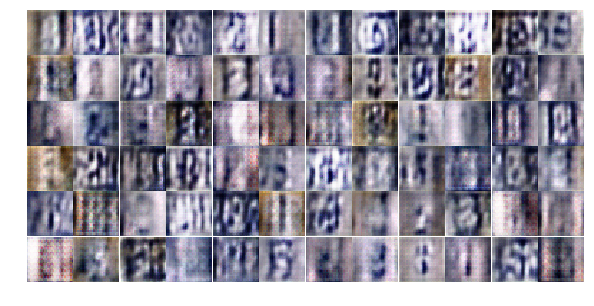

Epoch 4/25... Discriminator Loss: 1.2586... Generator Loss: 0.7909
Epoch 4/25... Discriminator Loss: 1.0750... Generator Loss: 1.0099
Epoch 4/25... Discriminator Loss: 1.1796... Generator Loss: 0.8605
Epoch 4/25... Discriminator Loss: 1.2344... Generator Loss: 0.8701
Epoch 4/25... Discriminator Loss: 1.0856... Generator Loss: 0.9494
Epoch 4/25... Discriminator Loss: 1.2669... Generator Loss: 0.6722
Epoch 4/25... Discriminator Loss: 1.4340... Generator Loss: 0.4821
Epoch 4/25... Discriminator Loss: 1.0443... Generator Loss: 1.1059
Epoch 4/25... Discriminator Loss: 1.0513... Generator Loss: 1.0661
Epoch 4/25... Discriminator Loss: 1.0383... Generator Loss: 0.8952


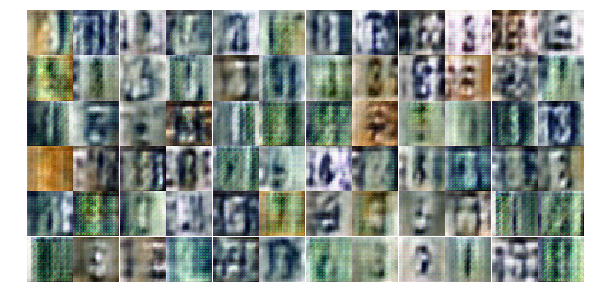

Epoch 4/25... Discriminator Loss: 1.3894... Generator Loss: 0.4503
Epoch 4/25... Discriminator Loss: 1.1515... Generator Loss: 0.7641
Epoch 4/25... Discriminator Loss: 1.0964... Generator Loss: 1.4866
Epoch 4/25... Discriminator Loss: 1.8282... Generator Loss: 0.2500
Epoch 4/25... Discriminator Loss: 1.1820... Generator Loss: 0.8891
Epoch 4/25... Discriminator Loss: 1.2715... Generator Loss: 1.1434
Epoch 4/25... Discriminator Loss: 0.9959... Generator Loss: 1.1543
Epoch 4/25... Discriminator Loss: 1.2357... Generator Loss: 1.0859
Epoch 4/25... Discriminator Loss: 1.0194... Generator Loss: 0.8581
Epoch 4/25... Discriminator Loss: 1.3444... Generator Loss: 0.9916


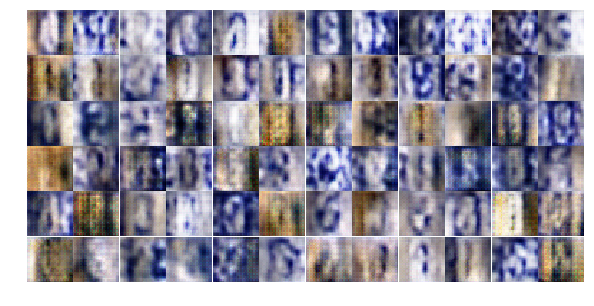

Epoch 4/25... Discriminator Loss: 1.1699... Generator Loss: 1.5236
Epoch 4/25... Discriminator Loss: 1.0360... Generator Loss: 0.7958
Epoch 4/25... Discriminator Loss: 0.9360... Generator Loss: 0.8549
Epoch 4/25... Discriminator Loss: 1.4408... Generator Loss: 1.8632
Epoch 4/25... Discriminator Loss: 1.2450... Generator Loss: 0.6012
Epoch 4/25... Discriminator Loss: 1.1295... Generator Loss: 0.9427
Epoch 4/25... Discriminator Loss: 0.6617... Generator Loss: 1.3573
Epoch 4/25... Discriminator Loss: 1.1324... Generator Loss: 1.1691
Epoch 4/25... Discriminator Loss: 1.2710... Generator Loss: 0.7267
Epoch 5/25... Discriminator Loss: 1.0072... Generator Loss: 1.0313


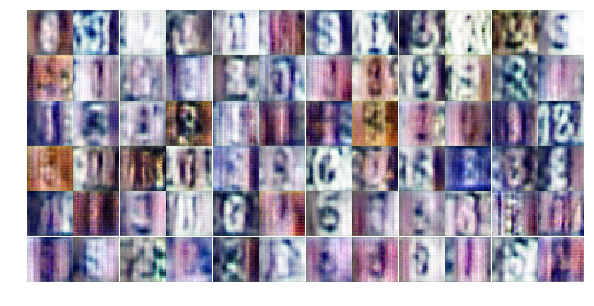

Epoch 5/25... Discriminator Loss: 1.2152... Generator Loss: 0.6603
Epoch 5/25... Discriminator Loss: 1.0773... Generator Loss: 0.9942
Epoch 5/25... Discriminator Loss: 1.1524... Generator Loss: 0.9615
Epoch 5/25... Discriminator Loss: 1.2219... Generator Loss: 0.5442
Epoch 5/25... Discriminator Loss: 1.0442... Generator Loss: 0.9596
Epoch 5/25... Discriminator Loss: 1.2600... Generator Loss: 0.6807
Epoch 5/25... Discriminator Loss: 1.1049... Generator Loss: 0.9500
Epoch 5/25... Discriminator Loss: 1.2074... Generator Loss: 0.7940
Epoch 5/25... Discriminator Loss: 1.1885... Generator Loss: 1.1997
Epoch 5/25... Discriminator Loss: 1.7143... Generator Loss: 0.3857


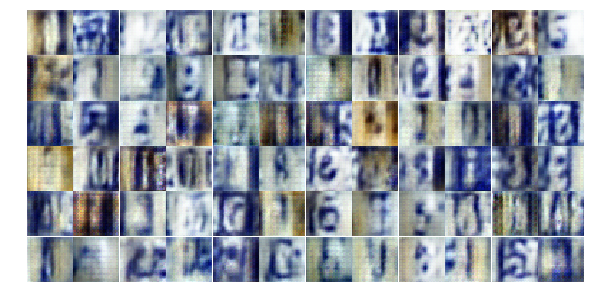

Epoch 5/25... Discriminator Loss: 0.9973... Generator Loss: 0.8130
Epoch 5/25... Discriminator Loss: 1.0345... Generator Loss: 1.1661
Epoch 5/25... Discriminator Loss: 1.0539... Generator Loss: 0.8111
Epoch 5/25... Discriminator Loss: 1.5417... Generator Loss: 0.4061
Epoch 5/25... Discriminator Loss: 1.5385... Generator Loss: 1.2510
Epoch 5/25... Discriminator Loss: 1.1727... Generator Loss: 0.6526
Epoch 5/25... Discriminator Loss: 1.2974... Generator Loss: 0.5857
Epoch 5/25... Discriminator Loss: 1.3752... Generator Loss: 0.6643
Epoch 5/25... Discriminator Loss: 1.1026... Generator Loss: 0.9518
Epoch 5/25... Discriminator Loss: 1.3447... Generator Loss: 0.5685


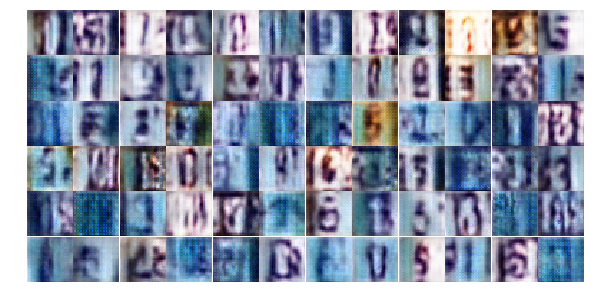

Epoch 5/25... Discriminator Loss: 1.1767... Generator Loss: 0.9537
Epoch 5/25... Discriminator Loss: 1.2800... Generator Loss: 0.6971
Epoch 5/25... Discriminator Loss: 1.3376... Generator Loss: 0.6276
Epoch 5/25... Discriminator Loss: 1.1537... Generator Loss: 0.8165
Epoch 5/25... Discriminator Loss: 1.1267... Generator Loss: 0.7338
Epoch 5/25... Discriminator Loss: 1.1666... Generator Loss: 1.1101
Epoch 5/25... Discriminator Loss: 1.1799... Generator Loss: 0.6474
Epoch 5/25... Discriminator Loss: 1.1347... Generator Loss: 0.7377
Epoch 5/25... Discriminator Loss: 1.4283... Generator Loss: 1.1534
Epoch 5/25... Discriminator Loss: 1.1842... Generator Loss: 0.9646


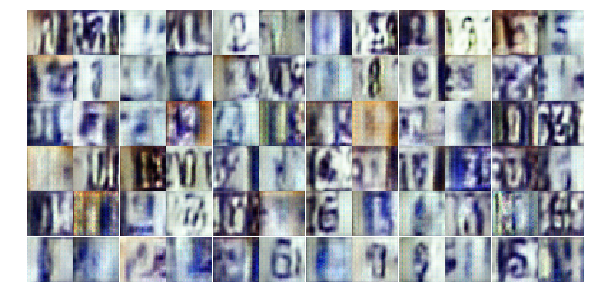

Epoch 5/25... Discriminator Loss: 1.2538... Generator Loss: 0.9680
Epoch 5/25... Discriminator Loss: 1.1369... Generator Loss: 0.7653
Epoch 5/25... Discriminator Loss: 1.0388... Generator Loss: 0.7905
Epoch 5/25... Discriminator Loss: 1.3891... Generator Loss: 1.0257
Epoch 5/25... Discriminator Loss: 1.2375... Generator Loss: 1.2785
Epoch 5/25... Discriminator Loss: 1.2249... Generator Loss: 1.1611
Epoch 5/25... Discriminator Loss: 1.1837... Generator Loss: 0.6485
Epoch 5/25... Discriminator Loss: 1.1306... Generator Loss: 0.7143
Epoch 5/25... Discriminator Loss: 1.2154... Generator Loss: 0.6588
Epoch 5/25... Discriminator Loss: 1.2755... Generator Loss: 0.5922


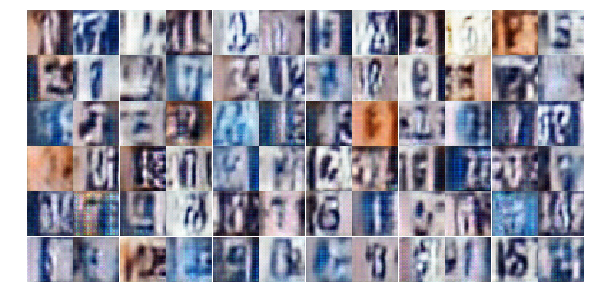

Epoch 5/25... Discriminator Loss: 1.4862... Generator Loss: 0.4496
Epoch 5/25... Discriminator Loss: 1.2615... Generator Loss: 0.5545
Epoch 5/25... Discriminator Loss: 1.2084... Generator Loss: 0.6657
Epoch 5/25... Discriminator Loss: 1.0177... Generator Loss: 0.9485
Epoch 5/25... Discriminator Loss: 1.7009... Generator Loss: 1.4101
Epoch 5/25... Discriminator Loss: 1.1094... Generator Loss: 0.9615
Epoch 5/25... Discriminator Loss: 1.1579... Generator Loss: 0.7690
Epoch 5/25... Discriminator Loss: 1.1101... Generator Loss: 0.7882
Epoch 5/25... Discriminator Loss: 1.1332... Generator Loss: 0.7865
Epoch 5/25... Discriminator Loss: 1.2559... Generator Loss: 0.7566


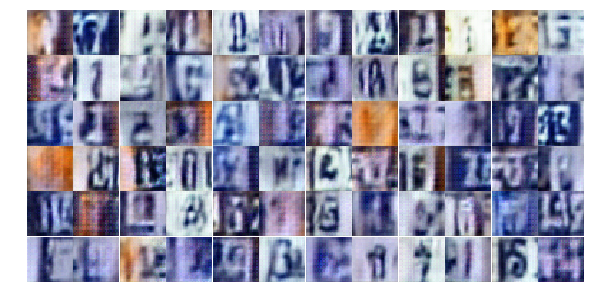

Epoch 5/25... Discriminator Loss: 1.4019... Generator Loss: 0.5098
Epoch 5/25... Discriminator Loss: 1.3106... Generator Loss: 0.5312
Epoch 5/25... Discriminator Loss: 1.4119... Generator Loss: 0.4904
Epoch 5/25... Discriminator Loss: 1.2999... Generator Loss: 0.4978
Epoch 5/25... Discriminator Loss: 1.2788... Generator Loss: 0.5853
Epoch 5/25... Discriminator Loss: 1.2711... Generator Loss: 0.6313
Epoch 6/25... Discriminator Loss: 1.2743... Generator Loss: 0.6037
Epoch 6/25... Discriminator Loss: 1.0931... Generator Loss: 1.0737
Epoch 6/25... Discriminator Loss: 1.5792... Generator Loss: 0.3135
Epoch 6/25... Discriminator Loss: 1.2288... Generator Loss: 0.5071


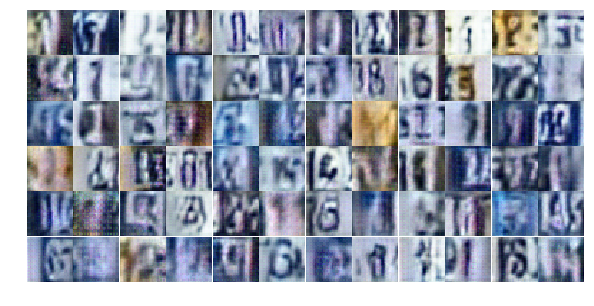

Epoch 6/25... Discriminator Loss: 1.2696... Generator Loss: 0.7703
Epoch 6/25... Discriminator Loss: 1.0652... Generator Loss: 0.8332
Epoch 6/25... Discriminator Loss: 1.1004... Generator Loss: 1.3230
Epoch 6/25... Discriminator Loss: 1.3866... Generator Loss: 0.5156
Epoch 6/25... Discriminator Loss: 1.2513... Generator Loss: 0.6427
Epoch 6/25... Discriminator Loss: 1.2909... Generator Loss: 0.6303
Epoch 6/25... Discriminator Loss: 1.1876... Generator Loss: 0.7069
Epoch 6/25... Discriminator Loss: 1.3772... Generator Loss: 0.5226
Epoch 6/25... Discriminator Loss: 1.7983... Generator Loss: 0.2594
Epoch 6/25... Discriminator Loss: 1.0775... Generator Loss: 0.9199


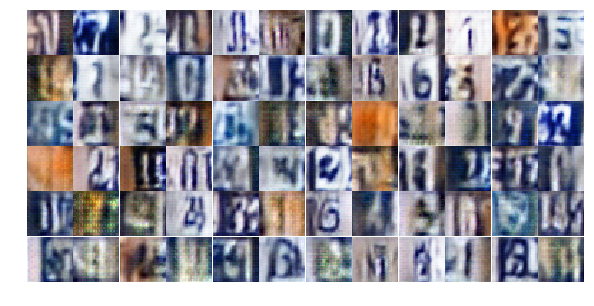

Epoch 6/25... Discriminator Loss: 1.2806... Generator Loss: 0.4983
Epoch 6/25... Discriminator Loss: 1.0645... Generator Loss: 1.1489
Epoch 6/25... Discriminator Loss: 1.4977... Generator Loss: 0.3548
Epoch 6/25... Discriminator Loss: 1.3286... Generator Loss: 0.5354
Epoch 6/25... Discriminator Loss: 1.1691... Generator Loss: 0.6346
Epoch 6/25... Discriminator Loss: 1.0843... Generator Loss: 1.1096
Epoch 6/25... Discriminator Loss: 1.2390... Generator Loss: 0.5422
Epoch 6/25... Discriminator Loss: 1.4677... Generator Loss: 0.3625
Epoch 6/25... Discriminator Loss: 1.2084... Generator Loss: 0.7421
Epoch 6/25... Discriminator Loss: 1.3988... Generator Loss: 1.4991


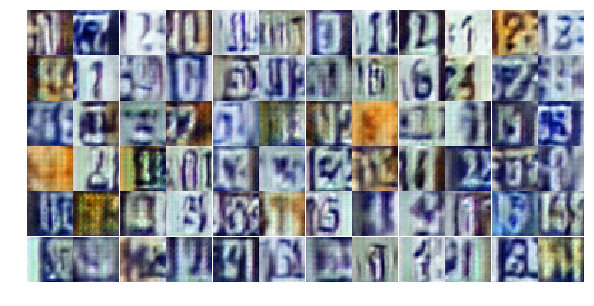

Epoch 6/25... Discriminator Loss: 1.2659... Generator Loss: 0.6191
Epoch 6/25... Discriminator Loss: 0.9958... Generator Loss: 0.7915
Epoch 6/25... Discriminator Loss: 1.1610... Generator Loss: 0.5097
Epoch 6/25... Discriminator Loss: 1.2359... Generator Loss: 0.5781
Epoch 6/25... Discriminator Loss: 1.1058... Generator Loss: 0.8707
Epoch 6/25... Discriminator Loss: 1.5486... Generator Loss: 0.4141
Epoch 6/25... Discriminator Loss: 1.2865... Generator Loss: 0.5210
Epoch 6/25... Discriminator Loss: 1.0176... Generator Loss: 1.0919
Epoch 6/25... Discriminator Loss: 1.1756... Generator Loss: 0.6979
Epoch 6/25... Discriminator Loss: 0.9682... Generator Loss: 1.0039


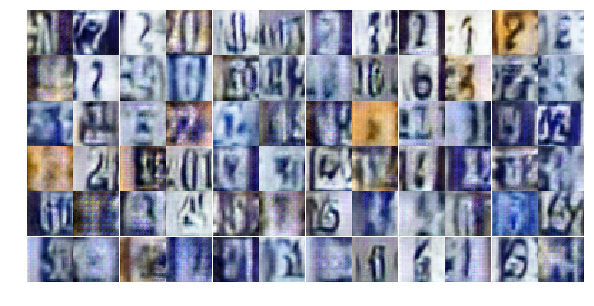

Epoch 6/25... Discriminator Loss: 1.3384... Generator Loss: 1.3448
Epoch 6/25... Discriminator Loss: 1.1827... Generator Loss: 1.0689
Epoch 6/25... Discriminator Loss: 1.3738... Generator Loss: 0.4815
Epoch 6/25... Discriminator Loss: 1.5405... Generator Loss: 0.4113
Epoch 6/25... Discriminator Loss: 1.2138... Generator Loss: 0.6960
Epoch 6/25... Discriminator Loss: 1.3143... Generator Loss: 0.5539
Epoch 6/25... Discriminator Loss: 1.1288... Generator Loss: 0.7342
Epoch 6/25... Discriminator Loss: 1.1539... Generator Loss: 1.2917
Epoch 6/25... Discriminator Loss: 1.3240... Generator Loss: 0.5849
Epoch 6/25... Discriminator Loss: 1.1394... Generator Loss: 0.5349


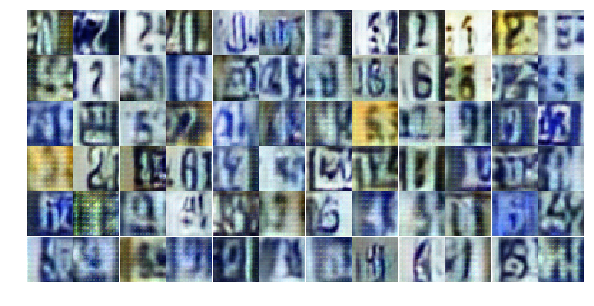

Epoch 6/25... Discriminator Loss: 1.1354... Generator Loss: 1.2953
Epoch 6/25... Discriminator Loss: 2.5225... Generator Loss: 0.1217
Epoch 6/25... Discriminator Loss: 1.2540... Generator Loss: 0.5701
Epoch 6/25... Discriminator Loss: 1.1065... Generator Loss: 0.8187
Epoch 6/25... Discriminator Loss: 1.2217... Generator Loss: 0.7486
Epoch 6/25... Discriminator Loss: 1.0583... Generator Loss: 1.0385
Epoch 6/25... Discriminator Loss: 1.3793... Generator Loss: 0.5122
Epoch 6/25... Discriminator Loss: 1.2004... Generator Loss: 0.5621
Epoch 6/25... Discriminator Loss: 0.9060... Generator Loss: 1.0796
Epoch 6/25... Discriminator Loss: 1.8006... Generator Loss: 0.2745


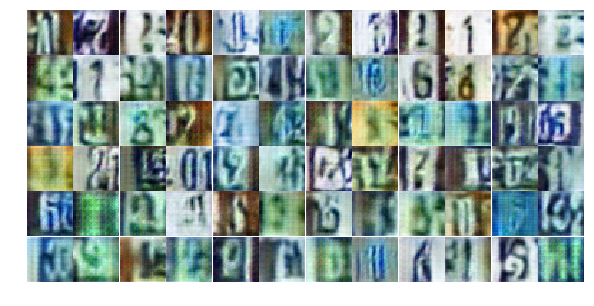

Epoch 6/25... Discriminator Loss: 0.9377... Generator Loss: 1.1673
Epoch 6/25... Discriminator Loss: 1.1341... Generator Loss: 0.9082
Epoch 6/25... Discriminator Loss: 0.9291... Generator Loss: 0.8182
Epoch 7/25... Discriminator Loss: 1.5859... Generator Loss: 0.3266
Epoch 7/25... Discriminator Loss: 1.0756... Generator Loss: 0.8271
Epoch 7/25... Discriminator Loss: 1.3167... Generator Loss: 0.6645
Epoch 7/25... Discriminator Loss: 1.3052... Generator Loss: 0.4883
Epoch 7/25... Discriminator Loss: 1.3029... Generator Loss: 0.6399
Epoch 7/25... Discriminator Loss: 0.9903... Generator Loss: 1.2506
Epoch 7/25... Discriminator Loss: 1.3083... Generator Loss: 1.3925


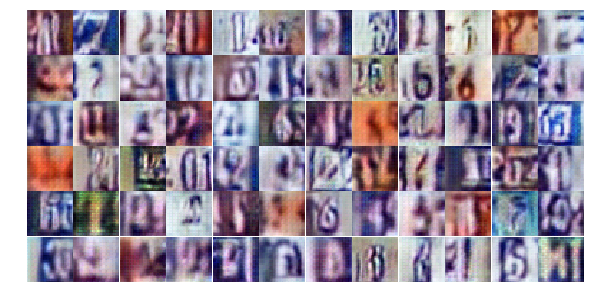

Epoch 7/25... Discriminator Loss: 1.0437... Generator Loss: 1.1062
Epoch 7/25... Discriminator Loss: 1.2166... Generator Loss: 0.8870
Epoch 7/25... Discriminator Loss: 0.9792... Generator Loss: 0.7905
Epoch 7/25... Discriminator Loss: 1.2387... Generator Loss: 0.5943
Epoch 7/25... Discriminator Loss: 1.1250... Generator Loss: 0.6839
Epoch 7/25... Discriminator Loss: 1.1239... Generator Loss: 1.3905
Epoch 7/25... Discriminator Loss: 1.3373... Generator Loss: 1.1827
Epoch 7/25... Discriminator Loss: 0.7934... Generator Loss: 1.5470
Epoch 7/25... Discriminator Loss: 1.1736... Generator Loss: 1.1906
Epoch 7/25... Discriminator Loss: 0.9652... Generator Loss: 1.0619


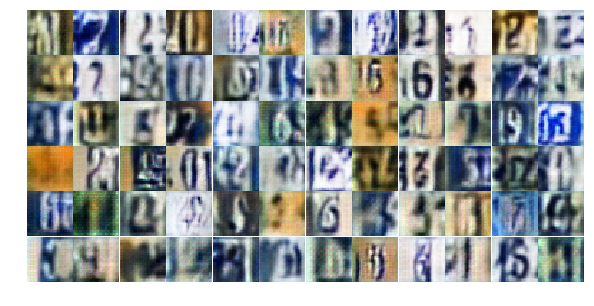

Epoch 7/25... Discriminator Loss: 1.4609... Generator Loss: 0.4971
Epoch 7/25... Discriminator Loss: 0.9390... Generator Loss: 0.8730
Epoch 7/25... Discriminator Loss: 0.9007... Generator Loss: 1.0899
Epoch 7/25... Discriminator Loss: 1.0270... Generator Loss: 0.9872
Epoch 7/25... Discriminator Loss: 1.1084... Generator Loss: 1.1136
Epoch 7/25... Discriminator Loss: 0.9531... Generator Loss: 1.1271
Epoch 7/25... Discriminator Loss: 0.9743... Generator Loss: 0.8461
Epoch 7/25... Discriminator Loss: 1.6847... Generator Loss: 0.2934
Epoch 7/25... Discriminator Loss: 0.6922... Generator Loss: 1.4505
Epoch 7/25... Discriminator Loss: 1.0995... Generator Loss: 0.8330


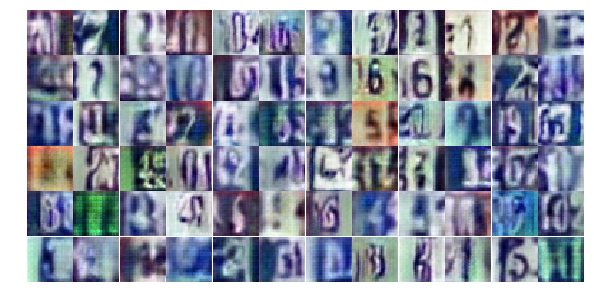

Epoch 7/25... Discriminator Loss: 1.2937... Generator Loss: 0.4694
Epoch 7/25... Discriminator Loss: 1.6838... Generator Loss: 0.3024
Epoch 7/25... Discriminator Loss: 1.0584... Generator Loss: 0.7855
Epoch 7/25... Discriminator Loss: 1.0807... Generator Loss: 0.7097
Epoch 7/25... Discriminator Loss: 1.2187... Generator Loss: 1.0297
Epoch 7/25... Discriminator Loss: 1.3644... Generator Loss: 0.4366
Epoch 7/25... Discriminator Loss: 1.3883... Generator Loss: 0.4591
Epoch 7/25... Discriminator Loss: 1.2689... Generator Loss: 0.5716
Epoch 7/25... Discriminator Loss: 0.9606... Generator Loss: 0.7685
Epoch 7/25... Discriminator Loss: 1.0530... Generator Loss: 1.2299


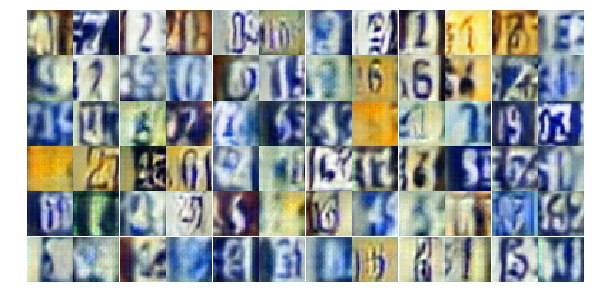

Epoch 7/25... Discriminator Loss: 1.5267... Generator Loss: 0.3710
Epoch 7/25... Discriminator Loss: 0.8504... Generator Loss: 1.8554
Epoch 7/25... Discriminator Loss: 0.8007... Generator Loss: 1.5251
Epoch 7/25... Discriminator Loss: 1.5421... Generator Loss: 1.0732
Epoch 7/25... Discriminator Loss: 1.3111... Generator Loss: 1.4266
Epoch 7/25... Discriminator Loss: 0.7763... Generator Loss: 0.9326
Epoch 7/25... Discriminator Loss: 1.3716... Generator Loss: 0.4120
Epoch 7/25... Discriminator Loss: 1.4446... Generator Loss: 0.9325
Epoch 7/25... Discriminator Loss: 0.7682... Generator Loss: 1.2589
Epoch 7/25... Discriminator Loss: 1.0427... Generator Loss: 0.6641


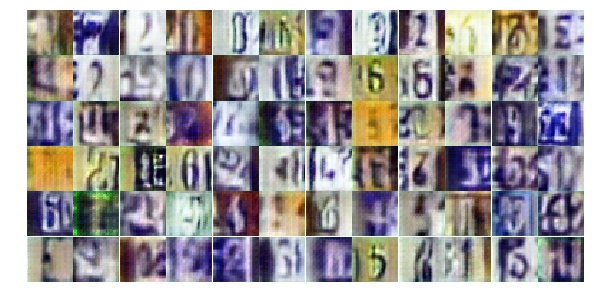

Epoch 7/25... Discriminator Loss: 0.9733... Generator Loss: 0.7943
Epoch 7/25... Discriminator Loss: 0.8280... Generator Loss: 1.1389
Epoch 7/25... Discriminator Loss: 0.8733... Generator Loss: 0.9343


In [ ]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))